# Spectral similarity

Compare different techniques to measure how similar 2 spectra are. As an evaluation data set, we use vibration data from motors, both healthy and falty. In the context of condition monitoring or predictive maintenance, discriminating both states is essential.

Data set can be found in https://mfpt.org/fault-data-sets/

In [1]:
%load_ext autoreload
%autoreload 2

from functools import partial
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine,euclidean,correlation

import similarity_utils as utils

%matplotlib inline

In [2]:
files = [
    '../MFPT Fault Data Sets/1 - Three Baseline Conditions/baseline_1.mat',
    '../MFPT Fault Data Sets/1 - Three Baseline Conditions/baseline_2.mat',
    '../MFPT Fault Data Sets/1 - Three Baseline Conditions/baseline_3.mat',
    '../MFPT Fault Data Sets/2 - Three Outer Race Fault Conditions/OuterRaceFault_1.mat',
    '../MFPT Fault Data Sets/2 - Three Outer Race Fault Conditions/OuterRaceFault_2.mat',
    '../MFPT Fault Data Sets/2 - Three Outer Race Fault Conditions/OuterRaceFault_3.mat',
    '../MFPT Fault Data Sets/3 - Seven More Outer Race Fault Conditions/OuterRaceFault_vload_1.mat',
    '../MFPT Fault Data Sets/3 - Seven More Outer Race Fault Conditions/OuterRaceFault_vload_2.mat',
    '../MFPT Fault Data Sets/3 - Seven More Outer Race Fault Conditions/OuterRaceFault_vload_3.mat',
    '../MFPT Fault Data Sets/3 - Seven More Outer Race Fault Conditions/OuterRaceFault_vload_4.mat',
    '../MFPT Fault Data Sets/3 - Seven More Outer Race Fault Conditions/OuterRaceFault_vload_5.mat',
    '../MFPT Fault Data Sets/3 - Seven More Outer Race Fault Conditions/OuterRaceFault_vload_6.mat',
]

In [3]:
data_dict = utils.load_data(files)

#### Overview on the spectrum for each set

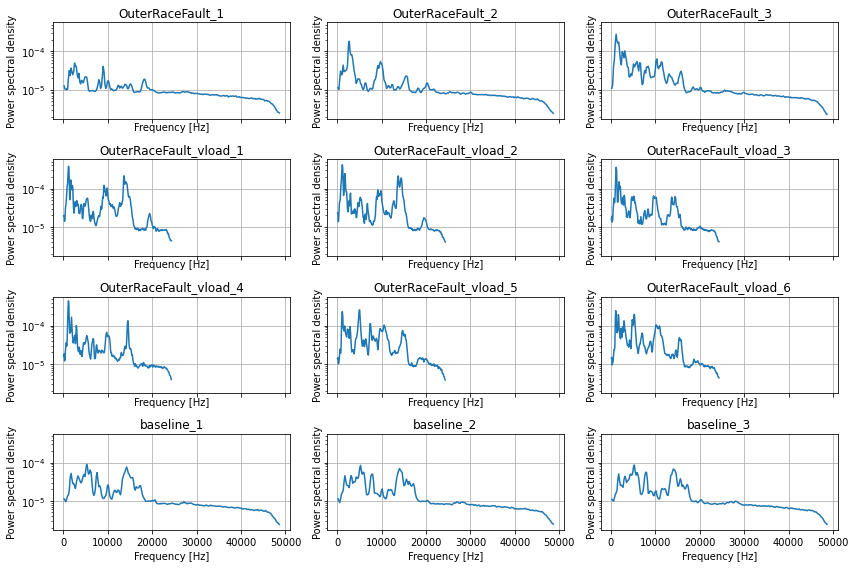

In [4]:
fig,axes = plt.subplots(len(data_dict)//3,3,figsize=(12,len(data_dict)//3*2),sharey=True,sharex=True)

for (key,value), ax in zip(sorted(data_dict.items()),axes.flatten()):
    freq, spectrum = signal.welch(value['gs'][:,0], fs=value['sr'], nperseg=500)
    ax.semilogy(freq[1:-1],spectrum[1:-1])
    ax.set_title(key)
    ax.grid()
    ax.set_xlabel('Frequency [Hz]')
    ax.set_ylabel('Power spectral density')
fig.tight_layout()

#### Calculate and store spectra for each subset

To give a certain degree of variability in the data set, we augment the provided vibration time series by splitting each one into equally spaced segments. Then, we use these time series segments to calculate individual spectra and carry on with the similarity analysis.

In [5]:
n_splits = 6
utils.init_data_dicts(data_dict,n_splits=n_splits,inplace=True);

### Pointwise similarity criteria

The methods for similarity we use in this study are based on comparing, point-by-point, two spectra. The outcome of each similarity comparison is a value that quantifies how similar they are. In this context, we say that two spectra are similar if it results a small  value.

In [7]:
def scc(a,b):
    """Squared correlation coefficient"""
    return correlation(a,b)**2

def dcc(a,b):
    """First difference correlation coefficient"""
    da = np.diff(a)
    db = np.diff(b)
    return correlation(da,db)

def dscc(a,b):
    """First difference squared correlation coefficient"""
    return dcc(a,b)**2

# Ref: Li, Jianfeng & Hibbert, David & Fuller, Stephen & Vaughn, Gary. (2006). A comparative study of point-to-point algorithms 
#      for matching spectra. Chemometrics and Intelligent Laboratory Systems - CHEMOMETR INTELL LAB SYST

In [8]:
similarity_functions = {
    "euclidean": partial(utils.compute_similarity,euclidean),
    "cosine": partial(utils.compute_similarity,cosine),
    "correlation": partial(utils.compute_similarity,correlation),
    "mahalanobis": utils.compute_mahalanobis_similarity,
    "scc": partial(utils.compute_similarity,scc),
    "dcc": partial(utils.compute_similarity,dcc),
    "dscc": partial(utils.compute_similarity,dscc),
}

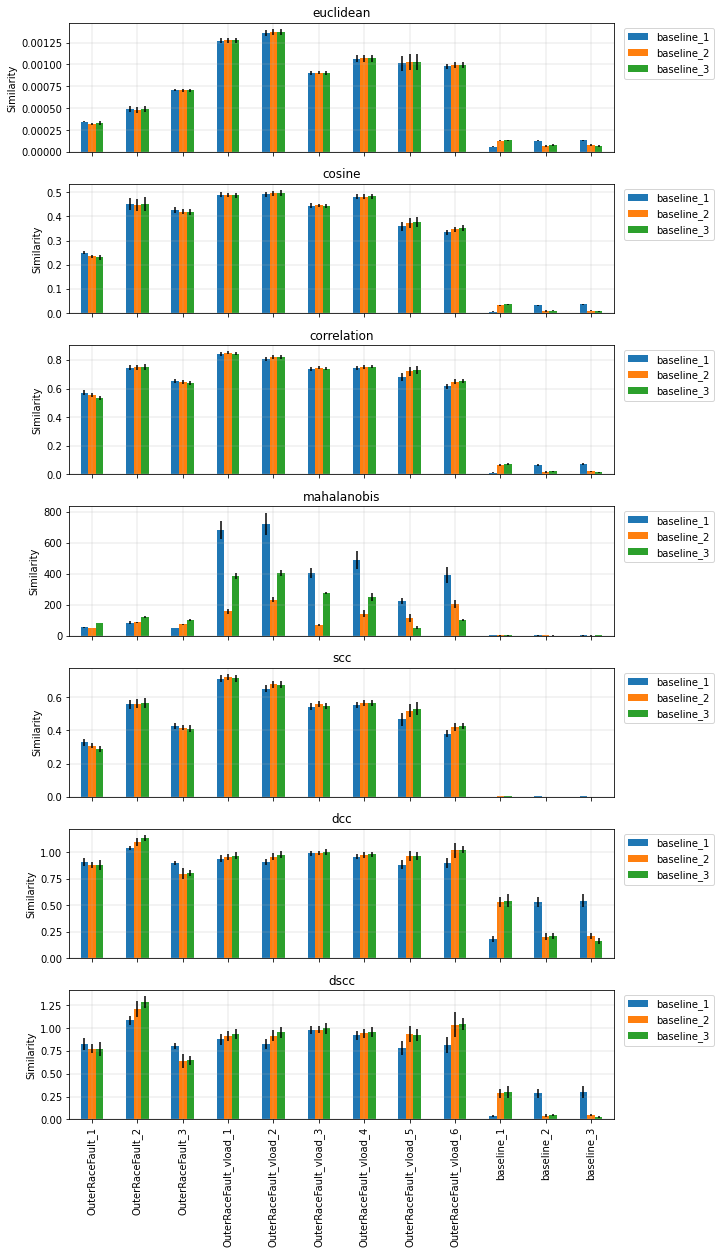

In [9]:
fig,ax = plt.subplots(len(similarity_functions),1,figsize=(10,len(similarity_functions)*2.5),sharex=True)
for (func_name, func), ax_ in zip(similarity_functions.items(),ax.flatten()):
    similarities = func(data_dict)
    df_mean = utils.plot_similarities_bar(['baseline_1','baseline_2','baseline_3'],similarities,ax=ax_)
    ax_.set_title(func_name)
fig.tight_layout(pad=1.0)

From these plots we can conclude that the **correlation** distance has showed to maintain great distances from the baseline to all the faulty sets, while having little variance across multiple splits and builti-in normalization. Therefore, for the goal of separating healthy and unhealthy samples by using only the distance between spectra, these attributes are quite handy. If we wanted to explore the discrimination between the multiple load conditions, the euclidean distance could be a good starting point, since this metric shows a better condition discrimination when compared with the baseline.